In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jogeuncheol","key":"4dca5e1842eb6568a7e359e204ae1c4d"}'}

In [3]:
ls -1ha kaggle.json

kaggle.json


In [4]:
!mkdir -p ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d vitaminc/cigarette-smoker-detection

 99% 2.48G/2.50G [00:20<00:00, 158MB/s]
100% 2.50G/2.50G [00:20<00:00, 129MB/s]


In [8]:
!unzip cigarette-smoker-detection.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: data/data/smoking/000335.jpg  
  inflating: data/data/smoking/000337.jpg  
  inflating: data/data/smoking/000338.jpg  
  inflating: data/data/smoking/000339.jpg  
  inflating: data/data/smoking/000343.jpg  
  inflating: data/data/smoking/000344.jpg  
  inflating: data/data/smoking/000352.jpg  
  inflating: data/data/smoking/000353.jpg  
  inflating: data/data/smoking/000354.png  
  inflating: data/data/smoking/000356.jpg  
  inflating: data/data/smoking/000357.jpg  
  inflating: data/data/smoking/000359.jpg  
  inflating: data/data/smoking/000362.jpg  
  inflating: data/data/smoking/000363.jpg  
  inflating: data/data/smoking/000365.jpg  
  inflating: data/data/smoking/000365.png  
  inflating: data/data/smoking/000366.jpg  
  inflating: data/data/smoking/000367.jpg  
  inflating: data/data/smoking/000369.jpg  
  inflating: data/data/smoking/000371.jpg  
  inflating: data/data/smoking/000372.jpg  
  inflating: data/data/smoking/000374.jp

In [9]:
!pip install imutils

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [11]:
dataset_path = '/content/data'
model_store_dir = 'smoking_detector.model'

In [12]:
INIT_LR = 1e-4
EPOCHS = 100
BS = 32
imagePaths = list(paths.list_images(dataset_path))

In [13]:
data = []
labels = []
for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)
  data.append(image)
  labels.append(label)
data = np.array(data, dtype="float32")
labels = np.array(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [14]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [15]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

9420800/9406464 [==============================] - 0s 0us/step


Epoch 1/100
162/162 [==============================] - 71s 416ms/step - loss: 0.1104 - accuracy: 0.9613 - val_loss: 0.1999 - val_accuracy: 0.9332
Epoch 2/100
162/162 [==============================] - 66s 408ms/step - loss: 0.1058 - accuracy: 0.9629 - val_loss: 0.1884 - val_accuracy: 0.9393
Epoch 3/100
162/162 [==============================] - 67s 413ms/step - loss: 0.1082 - accuracy: 0.9623 - val_loss: 0.1976 - val_accuracy: 0.9370
Epoch 4/100
162/162 [==============================] - 66s 410ms/step - loss: 0.1027 - accuracy: 0.9642 - val_loss: 0.1965 - val_accuracy: 0.9386
Epoch 5/100
162/162 [==============================] - 66s 406ms/step - loss: 0.1055 - accuracy: 0.9602 - val_loss: 0.1833 - val_accuracy: 0.9424
Epoch 6/100
162/162 [==============================] - 66s 404ms/step - loss: 0.1040 - accuracy: 0.9631 - val_loss: 0.1838 - val_accuracy: 0.9386
Epoch 7/100
162/162 [==============================] - 65s 403ms/step - loss: 0.1093 - accuracy: 0.9627 - val_loss: 0.1822 -

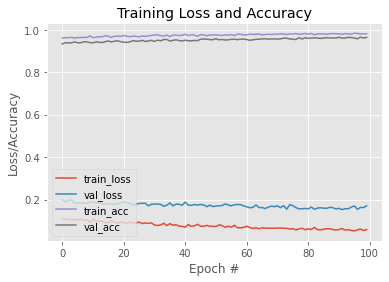

In [18]:
for layer in baseModel.layers:
  layer.trainable = False
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

model.save(model_store_dir, save_format='h5')
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("ploy.jpg")